# Torchlens: A Package for Extracting and Understanding the Results of Every Operation Performed in a PyTorch Model in One Line of Code

**Torchlens** is a Python package for easily extracting and understanding the results of every single operation performed inside a PyTorch neural network model.  Its core functionality includes:
1. extracting the activations from any (and every, if you want) intermediate computation inside a PyTorch neural network model,
2. fully characterizing where those activations come from, via providing a complete log of every operation that happens during a model's forward pass, and
3. visualizing the complete computation graph of the model's forward pass.

This notebook demonstrates how to use torchlens.

In [1]:
from cornet import cornet_s
import torch
from torch import nn
import torchvision
import torchlens as tl

### The core function of torchlens: get_model_activations

The core function in torchlens is get_model_activations. Simply give it the model (as-is, with no changes necessary) and input, and it'll take care of everything else, and return an object containing a log of everything that happened during the model's forward pass, including not just the activations, but also lots of information about the model's full computation graph. By setting vis_opt to 'unrolled' or 'rolled', it will also visualize the computation graph for us (more on this visual later). If you simply wish to save all the activations from a model, a single call to this function is all you need.

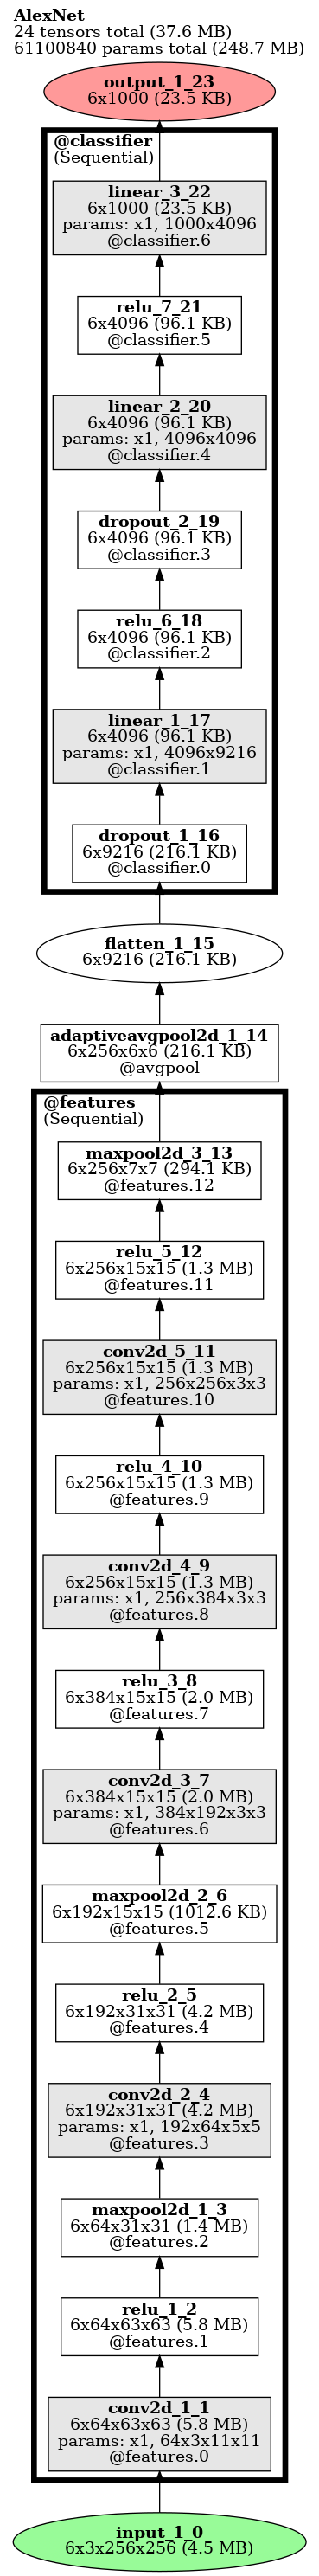

Log of AlexNet forward pass:
	Model structure: purely feedforward, without branching; 23 total modules.
	24 tensors (37.6 MB) computed in forward pass; 24 tensors (37.6 MB) saved.
	16 parameter operations (61100840 params total; 248.7 MB).
	Random seed: 2474132503
	Time elapsed: 2.831s
	Module Hierarchy:
		features:
		    features.0, features.1, features.2, features.3, features.4, features.5, features.6, features.7, 
		    features.8, features.9, features.10, features.11, features.12
		avgpool
		classifier:
		    classifier.0, classifier.1, classifier.2, classifier.3, classifier.4, classifier.5, classifier.6
	Layers:
		0: input_1_0 
		1: conv2d_1_1 
		2: relu_1_2 
		3: maxpool2d_1_3 
		4: conv2d_2_4 
		5: relu_2_5 
		6: maxpool2d_2_6 
		7: conv2d_3_7 
		8: relu_3_8 
		9: conv2d_4_9 
		10: relu_4_10 
		11: conv2d_5_11 
		12: relu_5_12 
		13: maxpool2d_3_13 
		14: adaptiveavgpool2d_1_14 
		15: flatten_1_15 
		16: dropout_1_16 
		17: linear_1_17 
		18: relu_6_18 
		19: dropout_2_19 
		20:

In [2]:
alexnet = torchvision.models.alexnet(pretrained=True)
x = torch.rand(6, 3, 256, 256)
model_history = tl.get_model_activations(alexnet, x, vis_opt='unrolled')
model_history

From the model_history object, we can pull out the results of any operation that happened in the model's forward pass just by indexing this object. By default, operations are named with the convention that (for instance)  "conv2d_4_9" means the 4th convolution operation, and the 9th operation overall:

In [3]:
model_history['conv2d_4_9']

Layer conv2d_4_9, operation 10/24:
	Output tensor: shape=(6, 256, 15, 15), dype=torch.float32, size=1.3 MB
		tensor([[ 1.8016,  1.3271,  0.9686,  1.6224,  0.8302],
        [ 1.7268, -0.0973, -2.0116, -2.7238, -2.9621],
        [ 0.8663, -0.0956, -2.8594, -3.3907, -3.3734],
        [-0.0288, -0.9059, -3.0037, -3.1878, -4.1136],
        [ 0.3965, -1.0983, -3.4304, -3.7034, -4.7422]])...
	Params: Computed from params with shape (256,), (256, 384, 3, 3); 884992 params total (3.4 MB)
	Parent Layers: relu_3_8
	Child Layers: relu_4_10
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.8
	Time elapsed:  1.725E-02s
	Output of modules: features.8
	Output of bottom-level module: features.8
	Lookup keys: -15, 9, conv2d_4_9, conv2d_4_9:1, features.8, features.8:1

To pull out the actual activations, just get the tensor_contents field from the layer object:


In [4]:
model_history['conv2d_4_9'].tensor_contents

tensor([[[[ 1.8016e+00,  1.3271e+00,  9.6855e-01,  ...,  1.1809e+00,
            1.9762e+00,  2.3754e+00],
          [ 1.7268e+00, -9.7346e-02, -2.0116e+00,  ..., -3.5114e+00,
           -8.4447e-01,  9.9602e-01],
          [ 8.6628e-01, -9.5616e-02, -2.8594e+00,  ..., -5.5225e+00,
           -1.0590e+00,  5.6071e-01],
          ...,
          [ 5.7302e-01, -1.8704e+00, -2.3015e+00,  ..., -2.8997e+00,
            8.3280e-01,  9.5229e-01],
          [-4.6508e-01, -2.4803e+00, -3.2398e+00,  ..., -3.1362e+00,
            1.8057e-01,  2.3994e-01],
          [ 2.9221e+00,  2.8463e+00,  3.6718e+00,  ...,  3.3347e+00,
            5.3510e+00,  4.7473e+00]],

         [[-5.2863e+00, -5.1783e+00, -4.9886e+00,  ..., -5.6957e+00,
           -7.3360e+00, -6.1596e+00],
          [-6.7717e+00, -6.2459e+00, -4.7350e+00,  ..., -5.8745e+00,
           -8.3723e+00, -7.2445e+00],
          [-5.7953e+00, -5.3934e+00, -3.9552e+00,  ..., -4.0438e+00,
           -6.5533e+00, -7.5030e+00],
          ...,
     

Torchlens also allows you to pull out the results of operations based on their ordinal position in the network, just like indexing a list:

In [5]:
print("*****These are the activations from the first layer*****")
print(model_history[1])
print("\n\n*****These are the activations from the fifth layer*****")
print(model_history[5])
print("\n\n*****These are the activations from the fourth-to-last layer*****")
print(model_history[-4])

*****These are the activations from the first layer*****
Layer conv2d_1_1, operation 2/24:
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
		tensor([[-0.1338, -1.2517, -2.1786, -0.8655,  0.1385],
        [-0.8128, -1.9210, -1.0100, -1.5671, -1.5976],
        [-1.1669, -1.8804, -0.5251, -0.0359, -0.4727],
        [-1.5071, -0.6606,  0.4129, -0.9252, -1.4492],
        [-0.1704, -0.4296, -1.6594, -1.7692, -1.6106]])...
	Params: Computed from params with shape (64,), (64, 3, 11, 11); 23296 params total (91.1 KB)
	Parent Layers: input_1_0
	Child Layers: relu_1_2
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.0
	Time elapsed:  3.129E-02s
	Output of modules: features.0
	Output of bottom-level module: features.0
	Lookup keys: -23, 1, conv2d_1_1, conv2d_1_1:1, features.0, features.0:1


*****These are the activations from the fifth layer*****
Layer relu_2_5, operation 6/24:
	Output tensor: shape=(6, 192, 31, 31), dype=torch.float32, siz

Finally, you can also pull out activations based on any modules for which they are the output (at any level of module nesting):


In [6]:
print("*****These are the activations from the 'features' module of AlexNet (prior to the fully connected layers)*****")
print(model_history['features'])
print("\n\n*****These are the activations from the third submodule in the 'classifier' module of AlexNet*****")
print(model_history['classifier.2'])

*****These are the activations from the 'features' module of AlexNet (prior to the fully connected layers)*****
Layer maxpool2d_3_13, operation 14/24:
	Output tensor: shape=(6, 256, 7, 7), dype=torch.float32, size=294.1 KB
		tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])...
	Params: no params used
	Parent Layers: relu_5_12
	Child Layers: adaptiveavgpool2d_1_14
	Function: max_pool2d (gradfunc=MaxPool2DWithIndicesBackward) 
	Computed inside module: features.12
	Time elapsed:  8.067E-03s
	Output of modules: features.12, features
	Output of bottom-level module: features.12
	Lookup keys: -11, 13, features, features.12, features.12:1, features:1, maxpool2d_3_13, maxpool2d_3_13:1


*****These are the activations from the third submodule in the 'classifier' module of AlexNet*****
Layer relu_6_18, operation 19/24:
	Output tensor: shape=(6, 4096), dype=torch.float32, size=96.1 KB
		tensor([[0.

You can iterate through the different layers like a list, and "len" will give the number of layers in the model.


In [7]:
print(len(model_history))
for layer in model_history:
    print(layer)

24
Layer input_1_0, operation 1/24:
	Output tensor: shape=(6, 3, 256, 256), dype=torch.float32, size=4.5 MB
		tensor([[0.9521, 0.5495, 0.1213, 0.9177, 0.8608],
        [0.7750, 0.8325, 0.3852, 0.7325, 0.4530],
        [0.3801, 0.7202, 0.7273, 0.6345, 0.1586],
        [0.4117, 0.5319, 0.8103, 0.3069, 0.5641],
        [0.4477, 0.2084, 0.0468, 0.4675, 0.3957]])...
	Params: no params used
	Parent Layers: no parent layers
	Child Layers: conv2d_1_1
	Output of modules: none
	Lookup keys: -24, 0, input_1_0, input_1_0:1
Layer conv2d_1_1, operation 2/24:
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
		tensor([[-0.1338, -1.2517, -2.1786, -0.8655,  0.1385],
        [-0.8128, -1.9210, -1.0100, -1.5671, -1.5976],
        [-1.1669, -1.8804, -0.5251, -0.0359, -0.4727],
        [-1.5071, -0.6606,  0.4129, -0.9252, -1.4492],
        [-0.1704, -0.4296, -1.6594, -1.7692, -1.6106]])...
	Params: Computed from params with shape (64,), (64, 3, 11, 11); 23296 params total (91.1 KB)
	Pa

You should use whatever indexing method makes the most sense for your use case.

### Understanding a model's activations without saving them: show_model_graph and get_model_structure

By default, torchlens saves the results of all the intermediate operations in a model. This will always only take just one line of code. However, for big models this might eat up a lot of memory, and maybe you want to take a look at what's going on in the model first so you can choose which layers you want. In this case, two other functions will come in handy (note that these provide just a subset of the functionality of get_model_activations):

1. show_model_graph, which will visualize the model's forward pass without saving any activations, and
2. get_model_structure, which will pull out all the same graph metadata (in the same format) as get_model_activations without saving the tensors themselves.


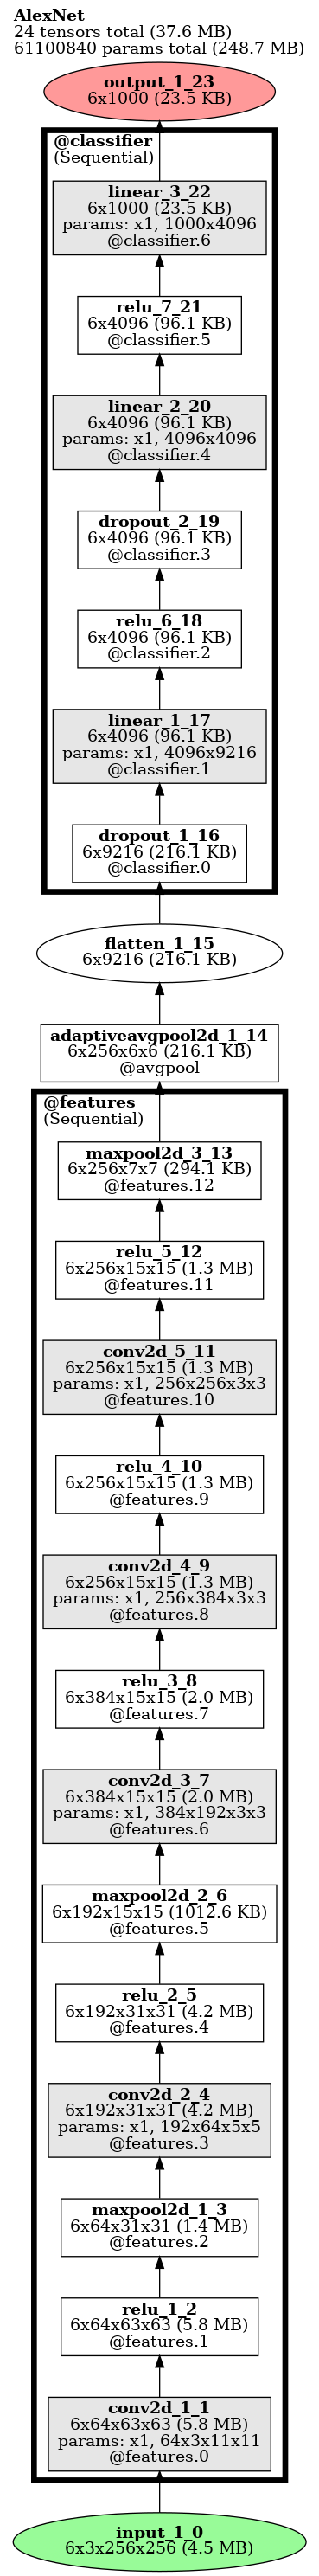

In [8]:
tl.show_model_graph(alexnet, x)

Let's look at the graph visual more closely; it shows you everything that happens in the model's forward pass:
- Each node of the graph is a tensor, with input tensors in green, output tensors in red, and tensors from operations associated with parameters in grey (e.g., convolutions are grey since they have saved weights, whereas relus are white, since they have no saved parameters).
- Nodes are rectangular if they correspond to outputs of a module (e.g., conv2d_1_1), and ovals if they are outputs of operations that are not a module (e.g., flatten_1_15).
- The text in each node tells you the layer name (e.g., conv2d_1_1), the shape and file size of the output tensor, the shape of any params if applicable, and the "module address" of the layer (e.g., 'features.1' refers to the module features.1 of AlexNet).
- Box outlines show higher-level modules that contain multiple operations (e.g., AlexNet's 'features' module).
- Finally, the visual also indicates the total number of tensors saved and their collective file size, along with the number of model parameters and associated file size.

Let's look at the structure of the model using get_model_structure; remember that this gives the exact same metadata as get_model_activations, but just doesn't save any activations. Simply printing the object will give us some information about what happens during the forward pass, including information about the structure of the model, the total size of the internal activations, the time elapsed during the forward pass, the module hierarchy (i.e., which modules are contained inside of other modules), and labels for all of the model layers.

In [9]:
model_structure = tl.get_model_structure(alexnet, x)
model_structure

Log of AlexNet forward pass:
	Model structure: purely feedforward, without branching; 23 total modules.
	24 tensors (37.6 MB) computed in forward pass; 0 tensors (0 B) saved.
	16 parameter operations (61100840 params total; 248.7 MB).
	Random seed: 957032754
	Time elapsed: 1.157s
	Module Hierarchy:
		features:
		    features.0, features.1, features.2, features.3, features.4, features.5, features.6, features.7, 
		    features.8, features.9, features.10, features.11, features.12
		avgpool
		classifier:
		    classifier.0, classifier.1, classifier.2, classifier.3, classifier.4, classifier.5, classifier.6
	Layers:
		0: input_1_0 
		1: conv2d_1_1 
		2: relu_1_2 
		3: maxpool2d_1_3 
		4: conv2d_2_4 
		5: relu_2_5 
		6: maxpool2d_2_6 
		7: conv2d_3_7 
		8: relu_3_8 
		9: conv2d_4_9 
		10: relu_4_10 
		11: conv2d_5_11 
		12: relu_5_12 
		13: maxpool2d_3_13 
		14: adaptiveavgpool2d_1_14 
		15: flatten_1_15 
		16: dropout_1_16 
		17: linear_1_17 
		18: relu_6_18 
		19: dropout_2_19 
		20: linea

And we can get information about a particular step by indexing model_structure, including information about the outputs of the layer, the parent and child layers, the module location of the layer, the layer parameters, and so on. Other information is saved too; you can use Python's 'dir' command to see what other information is available.


In [10]:
print(model_structure['conv2d_1_1'])
print(dir(model_structure['conv2d_1_1']))

Layer conv2d_1_1, operation 2/24:
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
	Params: Computed from params with shape (64,), (64, 3, 11, 11); 23296 params total (91.1 KB)
	Parent Layers: input_1_0
	Child Layers: relu_1_2
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.0
	Time elapsed:  3.906E-02s
	Output of modules: features.0
	Output of bottom-level module: features.0
	Lookup keys: -23, 1, conv2d_1_1, conv2d_1_1:1, features.0, features.0:1
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'bottom_level_module_exited', 'child_layers', 'computed_from_params', 'containing_origin_module', 'containing_origin_modules_nested', 'func_applied

Now, suppose we decide based on inspecting all this that we don't want to save all the layers in AlexNet, but just the outputs of the convolutional layers. We can call get_model_activations again, but this time tell it which layers we want; for instance, perhaps we only want the outputs of the convolutional layers (the visual can help with getting the labels for these):


In [11]:
model_history = tl.get_model_activations(alexnet, x,
                                         which_layers=['conv2d_1_1', 'conv2d_2_4', 'conv2d_3_7', 'conv2d_4_9',
                                                       'conv2d_5_11'])
for layer in model_history:
    print(layer)

Layer conv2d_1_1, operation 2/24:
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
		tensor([[-0.1338, -1.2517, -2.1786, -0.8655,  0.1385],
        [-0.8128, -1.9210, -1.0100, -1.5671, -1.5976],
        [-1.1669, -1.8804, -0.5251, -0.0359, -0.4727],
        [-1.5071, -0.6606,  0.4129, -0.9252, -1.4492],
        [-0.1704, -0.4296, -1.6594, -1.7692, -1.6106]])...
	Params: Computed from params with shape (64,), (64, 3, 11, 11); 23296 params total (91.1 KB)
	Parent Layers: input_1_0
	Child Layers: relu_1_2
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.0
	Time elapsed:  3.532E-02s
	Output of modules: features.0
	Output of bottom-level module: features.0
	Lookup keys: -5, 0, conv2d_1_1, conv2d_1_1:1, features.0, features.0:1
Layer conv2d_2_4, operation 5/24:
	Output tensor: shape=(6, 192, 31, 31), dype=torch.float32, size=4.2 MB
		tensor([[ 2.1513,  2.9211,  2.3212,  1.2645,  1.9479],
        [ 1.9526, -0.5837, -0.6053, -1.8070, -1.1

We can also use model_struct to help us get our desired layers programmatically. For example, maybe we want to get all the relu layers:

In [12]:
model_struct = tl.get_model_structure(alexnet, x)
which_layers = []
for layer in model_struct:
    if layer.func_applied_name == 'relu':
        which_layers.append(layer.layer_barcode)
print(which_layers)
tl.get_model_activations(alexnet, x, which_layers)

['relu_1_2', 'relu_2_5', 'relu_3_8', 'relu_4_10', 'relu_5_12', 'relu_6_18', 'relu_7_21']


Log of AlexNet forward pass:
	Model structure: purely feedforward, without branching; 7 total modules.
	24 tensors (37.6 MB) computed in forward pass; 7 tensors (14.8 MB) saved.
	16 parameter operations (61100840 params total; 248.7 MB).
	Random seed: 1746461433
	Time elapsed: 1.535s
	Module Hierarchy:
		features:
		    features.0, features.1, features.2, features.3, features.4, features.5, features.6, features.7, 
		    features.8, features.9, features.10, features.11, features.12
		avgpool
		classifier:
		    classifier.0, classifier.1, classifier.2, classifier.3, classifier.4, classifier.5, classifier.6
	Layers:
		0: relu_1_2 
		1: relu_2_5 
		2: relu_3_8 
		3: relu_4_10 
		4: relu_5_12 
		5: relu_6_18 
		6: relu_7_21 

### Handling Recurrent Models

Sometimes your model may contain recurrent layers, where a given operation is applied multiple times with the same parameters. Torchlens fully supports such networks, and can visualize them in both "unrolled" format (showing each pass of each layer separately), or "rolled" format (indicating passes of a given layer as one node).


#### Unrolled graph visual

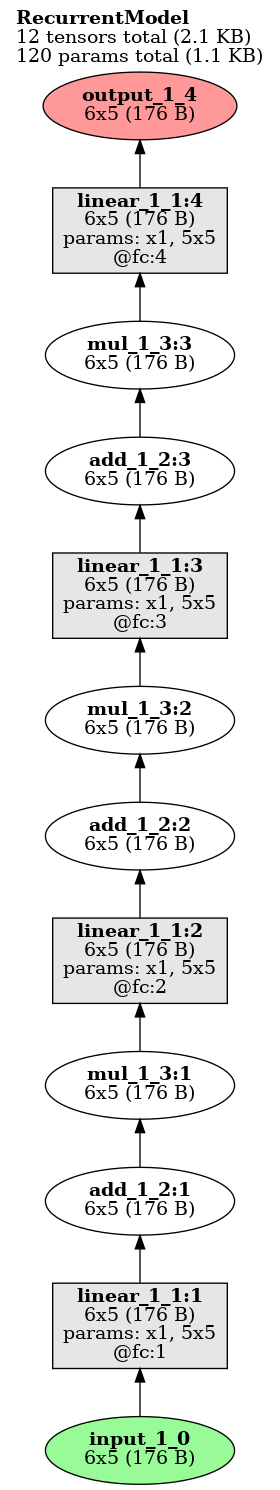

Log of RecurrentModel forward pass:
	Model structure: recurrent (at most 4 loops), without branching; 1 total modules.
	12 tensors (2.1 KB) computed in forward pass; 12 tensors (2.1 KB) saved.
	8 parameter operations (120 params total; 1.1 KB).
	Random seed: 650834471
	Time elapsed: 0.022s
	Module Hierarchy:
		fc
		fc
		fc
		fc
	Layers:
		0: input_1_0 
		1: linear_1_1:1  (1/4 passes)
		2: add_1_2:1  (1/3 passes)
		3: mul_1_3:1  (1/3 passes)
		4: linear_1_1:2  (2/4 passes)
		5: add_1_2:2  (2/3 passes)
		6: mul_1_3:2  (2/3 passes)
		7: linear_1_1:3  (3/4 passes)
		8: add_1_2:3  (3/3 passes)
		9: mul_1_3:3  (3/3 passes)
		10: linear_1_1:4  (4/4 passes)
		11: output_1_4 

In [13]:
class RecurrentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(in_features=5, out_features=5)

    def forward(self, x):
        x = self.fc(x)
        x = x + 1
        x = x * 2
        x = self.fc(x)
        x = x + 1
        x = x * 2
        x = self.fc(x)
        x = x + 1
        x = x * 2
        x = self.fc(x)
        return x


x = torch.rand(6, 5)
recurrent_mod = RecurrentModel()
tl.get_model_activations(recurrent_mod, x, vis_opt='unrolled')

Different passes of a layer are indicated with a colon: for instance, 'linear_1_1:2' means the second pass of this layer. By default, torchlens adopts the convention that different operations are considered part of the same "layer" if the same parameters are applied for those operations (e.g., here the same set of fully connected weights is applied four times during the forward pass), **or** if an operation follows such a layer (e.g., the add and multiply operations after each fully conencted layer in this example model).

#### Rolled graph visual

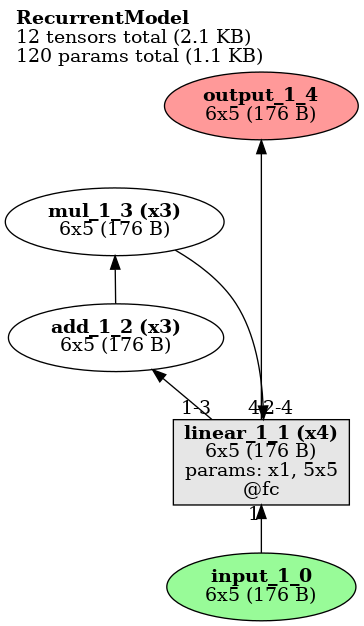

In [14]:
model_history = tl.get_model_activations(recurrent_mod, x, vis_opt='rolled')

In the rolled-up graph, if a layer has different inputs or outputs on different passes, the incoming or outgoing edges are marked with the passes for which they happen; for instance, looking at linear_1_1, you can see that in the first pass the input comes from input_1_0, but comes from mul_1_3 on passes 2-4, and its output goes to add_1_2 for its first three passes, but finally exits the loop and goes to output_1_4 on the 4th and final pass. The number of passes for each layer is indicated with, e.g., (x3) after the layer label to indicate three passes.

 Separate passes of a layer can be pulled out by indexing the model_history object as usual:

In [15]:
print(model_history['linear_1_1:3'])
print(model_history['add_1_2:1'])

Layer linear_1_1(pass 3/4), operation 8/12:
	Output tensor: shape=(6, 5), dype=torch.float32, size=176 B
		tensor([[ 1.8590, -1.8505,  0.7545,  0.6356,  1.9245],
        [ 3.0986, -1.1891,  0.3871,  0.1659,  1.5874],
        [ 1.9079, -1.8370,  0.6237,  0.6794,  1.7975],
        [ 2.5343, -1.5310,  0.4030,  0.4683,  1.6133],
        [ 1.5681, -1.8539,  0.9459,  0.6139,  2.0406]],
       grad_fn=<SliceBackward>)...
	Params: Computed from params with shape (5,), (5, 5); 30 params total (232 B)
	Parent Layers: mul_1_3:2
	Child Layers: add_1_2:3
	Function: linear (gradfunc=AddmmBackward) 
	Computed inside module: fc
	Time elapsed:  7.069E-04s
	Output of modules: fc
	Output of bottom-level module: fc
	Lookup keys: -5, 7, fc:3, linear_1_1:3
Layer add_1_2(pass 1/3), operation 3/12:
	Output tensor: shape=(6, 5), dype=torch.float32, size=176 B
		tensor([[0.6842, 0.4806, 1.0954, 1.4658, 1.7211],
        [0.8681, 0.9808, 1.5067, 1.1649, 1.7014],
        [0.7818, 0.6376, 0.7679, 1.4401, 1.5085],
 

## Model Examples

Torchlens can also deal with models that include complexities such as:

1. Branching, where the computational graph splits and later reconverges
2. If-then control flow that can change the computation graph based on input values
3. Tensors that are generated inside the network (e.g., with torch.ones, torch.zeros, torch.rand, etc.) rather than coming from the input
4. Models with a nested modular structure
5. Randomness (here, you can set the random seed to make sure you get the same outputs from each pass)

...and hopefully any other kind of model, too.

Note for these examples that no modifications are required to the models, or for any model, for torchlens to function.

#### Branching Model

In this model, the computation graph splits and later recombines. In such cases, the "order" of the layers (e.g., when indexing the model_history object) is defined via a topological sorting procedure such that a layer always comes before its descendants.

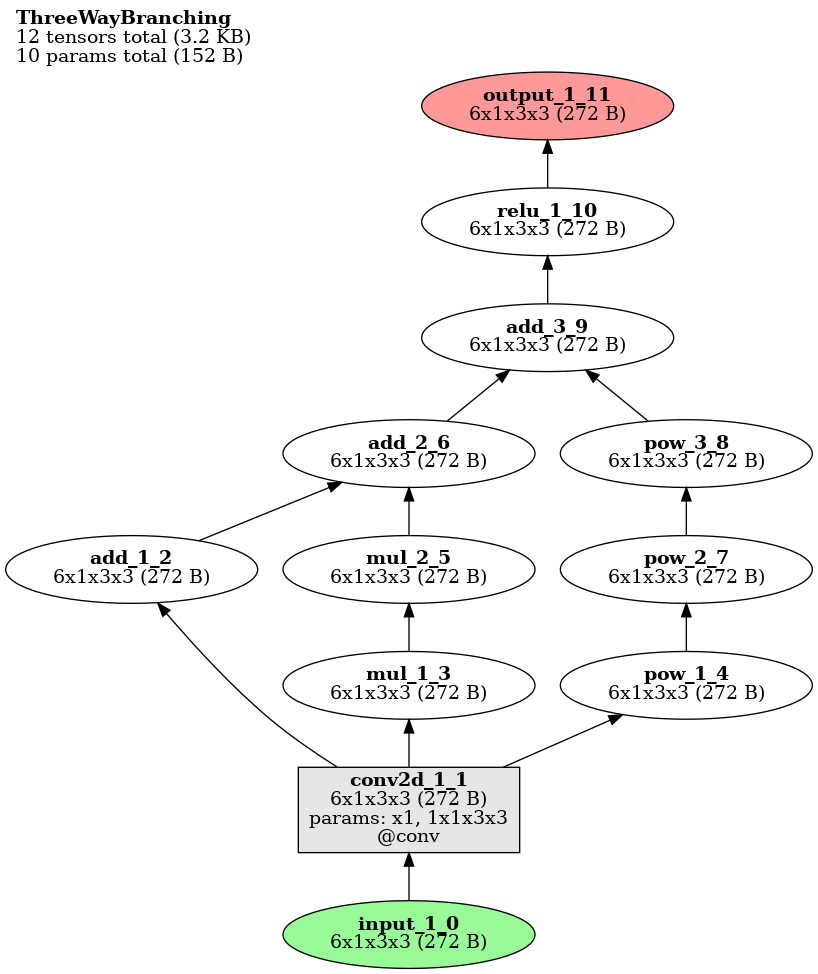

Log of ThreeWayBranching forward pass:
	Model structure: purely feedforward, with branching; 1 total modules.
	12 tensors (3.2 KB) computed in forward pass; 12 tensors (3.2 KB) saved.
	2 parameter operations (10 params total; 152 B).
	Random seed: 646451643
	Time elapsed: 0.035s
	Module Hierarchy:
		conv
	Layers:
		0: input_1_0 
		1: conv2d_1_1 
		2: add_1_2 
		3: mul_1_3 
		4: pow_1_4 
		5: mul_2_5 
		6: add_2_6 
		7: pow_2_7 
		8: pow_3_8 
		9: add_3_9 
		10: relu_1_10 
		11: output_1_11 

In [16]:
class ThreeWayBranching(nn.Module):
    def __init__(self):
        """Conv, relu, pool, fc, output.

        """
        super().__init__()
        self.conv = nn.Conv2d(1, 1, 3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        a = x + 1
        b = x * 2
        b = b * 3
        c = x ** 2
        c = c ** 3
        c = c ** 4
        x = a + b + c
        x = nn.functional.relu(x)
        return x


x = torch.rand(6, 1, 3, 3)
branching_model = ThreeWayBranching()
tl.get_model_activations(branching_model, x, vis_opt='unrolled')

#### If-then control flow

Here, the computation graph changes based on the value of the input (specifically, it does one sequence of computations if the sum of the input tensor is greater than zero, and a different sequence of computations otherwise). Torchlens will trace and visualize the computations that actually occur. Let's look at it with an input of all zeros first:

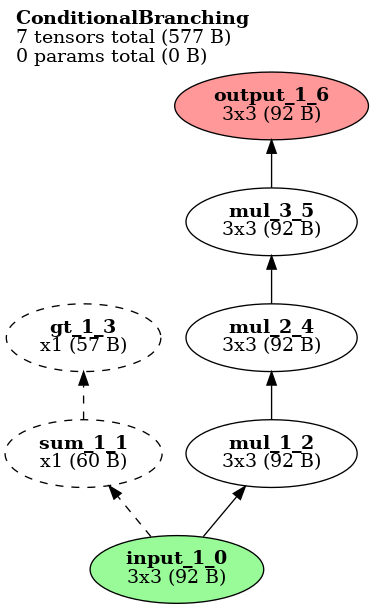

Log of ConditionalBranching forward pass:
	Model structure: purely feedforward, with branching; 0 total modules.
	7 tensors (577 B) computed in forward pass; 7 tensors (577 B) saved.
	0 parameter operations (0 params total; 0 B).
	Random seed: 584261027
	Time elapsed: 0.005s
	Module Hierarchy:
	Layers:
		0: input_1_0 
		1: sum_1_1 
		2: mul_1_2 
		3: gt_1_3 
		4: mul_2_4 
		5: mul_3_5 
		6: output_1_6 

In [17]:
class ConditionalBranching(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        if torch.sum(x) > 0:
            x = x + 1
            x = x + 1
            x = x + 1
        else:
            x = x * 2
            x = x * 2
            x = x * 2
        return x


conditional_model = ConditionalBranching()
zeros = torch.zeros(3, 3)
tl.get_model_activations(conditional_model, zeros, vis_opt='unrolled')

Also note that it tracks the tensors involved in evaluating the conditional "if" statement; these are indicated with dashed lines in the visual since they do not contribute directly to the eventual output.

Next do the same model with an all-ones tensor as input; note that the computation graph has changed accordingly, with a sequence of addition operations (instead of multiplication) being applied.

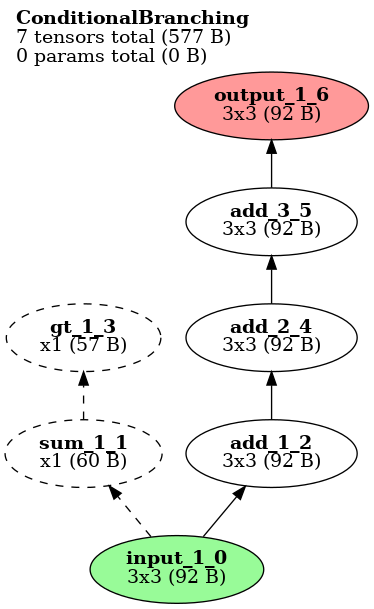

Log of ConditionalBranching forward pass:
	Model structure: purely feedforward, with branching; 0 total modules.
	7 tensors (577 B) computed in forward pass; 7 tensors (577 B) saved.
	0 parameter operations (0 params total; 0 B).
	Random seed: 711293235
	Time elapsed: 0.006s
	Module Hierarchy:
	Layers:
		0: input_1_0 
		1: sum_1_1 
		2: add_1_2 
		3: gt_1_3 
		4: add_2_4 
		5: add_3_5 
		6: output_1_6 

In [18]:
ones = torch.ones(3, 3)
tl.get_model_activations(conditional_model, ones, vis_opt='unrolled')

#### Models with internally generated tensors

Some models contain tensors that are not computed from the input, but later meet it downstream; for instance, perhaps you want to randomly generate noise to add at some step. Torchlens tracks these tensors too, and they are indicated with dashed outlines in the visual (if a model happens to have tensors that neither come from the input nor eventually contribute to the output, they are discarded at the end).

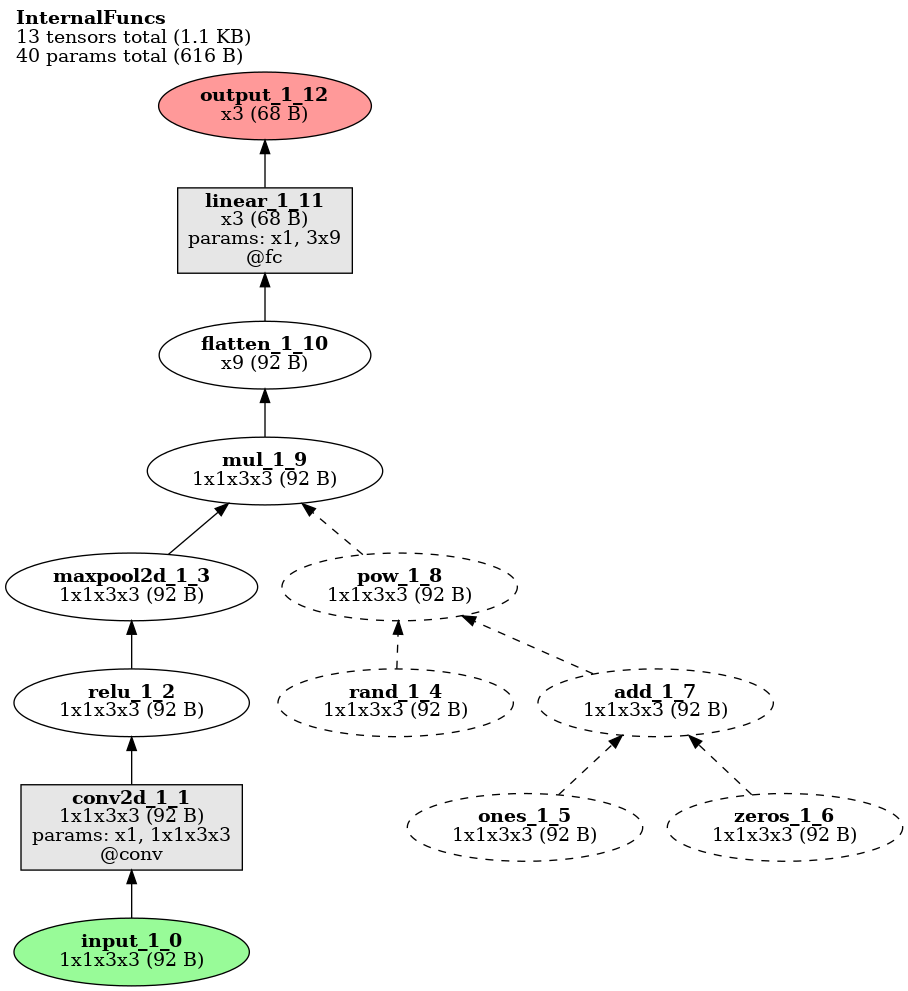

Log of InternalFuncs forward pass:
	Model structure: purely feedforward, without branching; 2 total modules.
	13 tensors (1.1 KB) computed in forward pass; 13 tensors (1.1 KB) saved.
	4 parameter operations (40 params total; 616 B).
	Random seed: 3421222214
	Time elapsed: 0.035s
	Module Hierarchy:
		conv
		fc
	Layers:
		0: input_1_0 
		1: conv2d_1_1 
		2: relu_1_2 
		3: maxpool2d_1_3 
		4: rand_1_4 
		5: ones_1_5 
		6: zeros_1_6 
		7: add_1_7 
		8: pow_1_8 
		9: mul_1_9 
		10: flatten_1_10 
		11: linear_1_11 
		12: output_1_12 

In [19]:
class InternalFuncs(nn.Module):
    def __init__(self):
        """Conv, relu, pool, fc, output.

        """
        super().__init__()
        self.conv = nn.Conv2d(1, 1, 3, padding=1)
        self.fc = nn.Linear(9, 3)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 1)
        y = torch.ones(1, 1, 3, 3) + torch.zeros(1, 1, 3, 3)
        z = torch.rand(1, 1, 3, 3) ** y
        x = x * z
        x = x.flatten()
        x = self.fc(x)
        return x


internal_funcs_model = InternalFuncs()
x = torch.rand(1, 1, 3, 3)
tl.get_model_activations(internal_funcs_model, x, vis_opt='unrolled')

#### Models with a nested module structure

Some models might have a hierarchically nested module structure, where modules contain submodules which themselves contain submodules. Torchlens automatically visualizes this modular structure by tracking tensors as they enter and exit modules in the model, and indicates this with nested boxes in the visual. Here is a model with multiple levels of nesting:

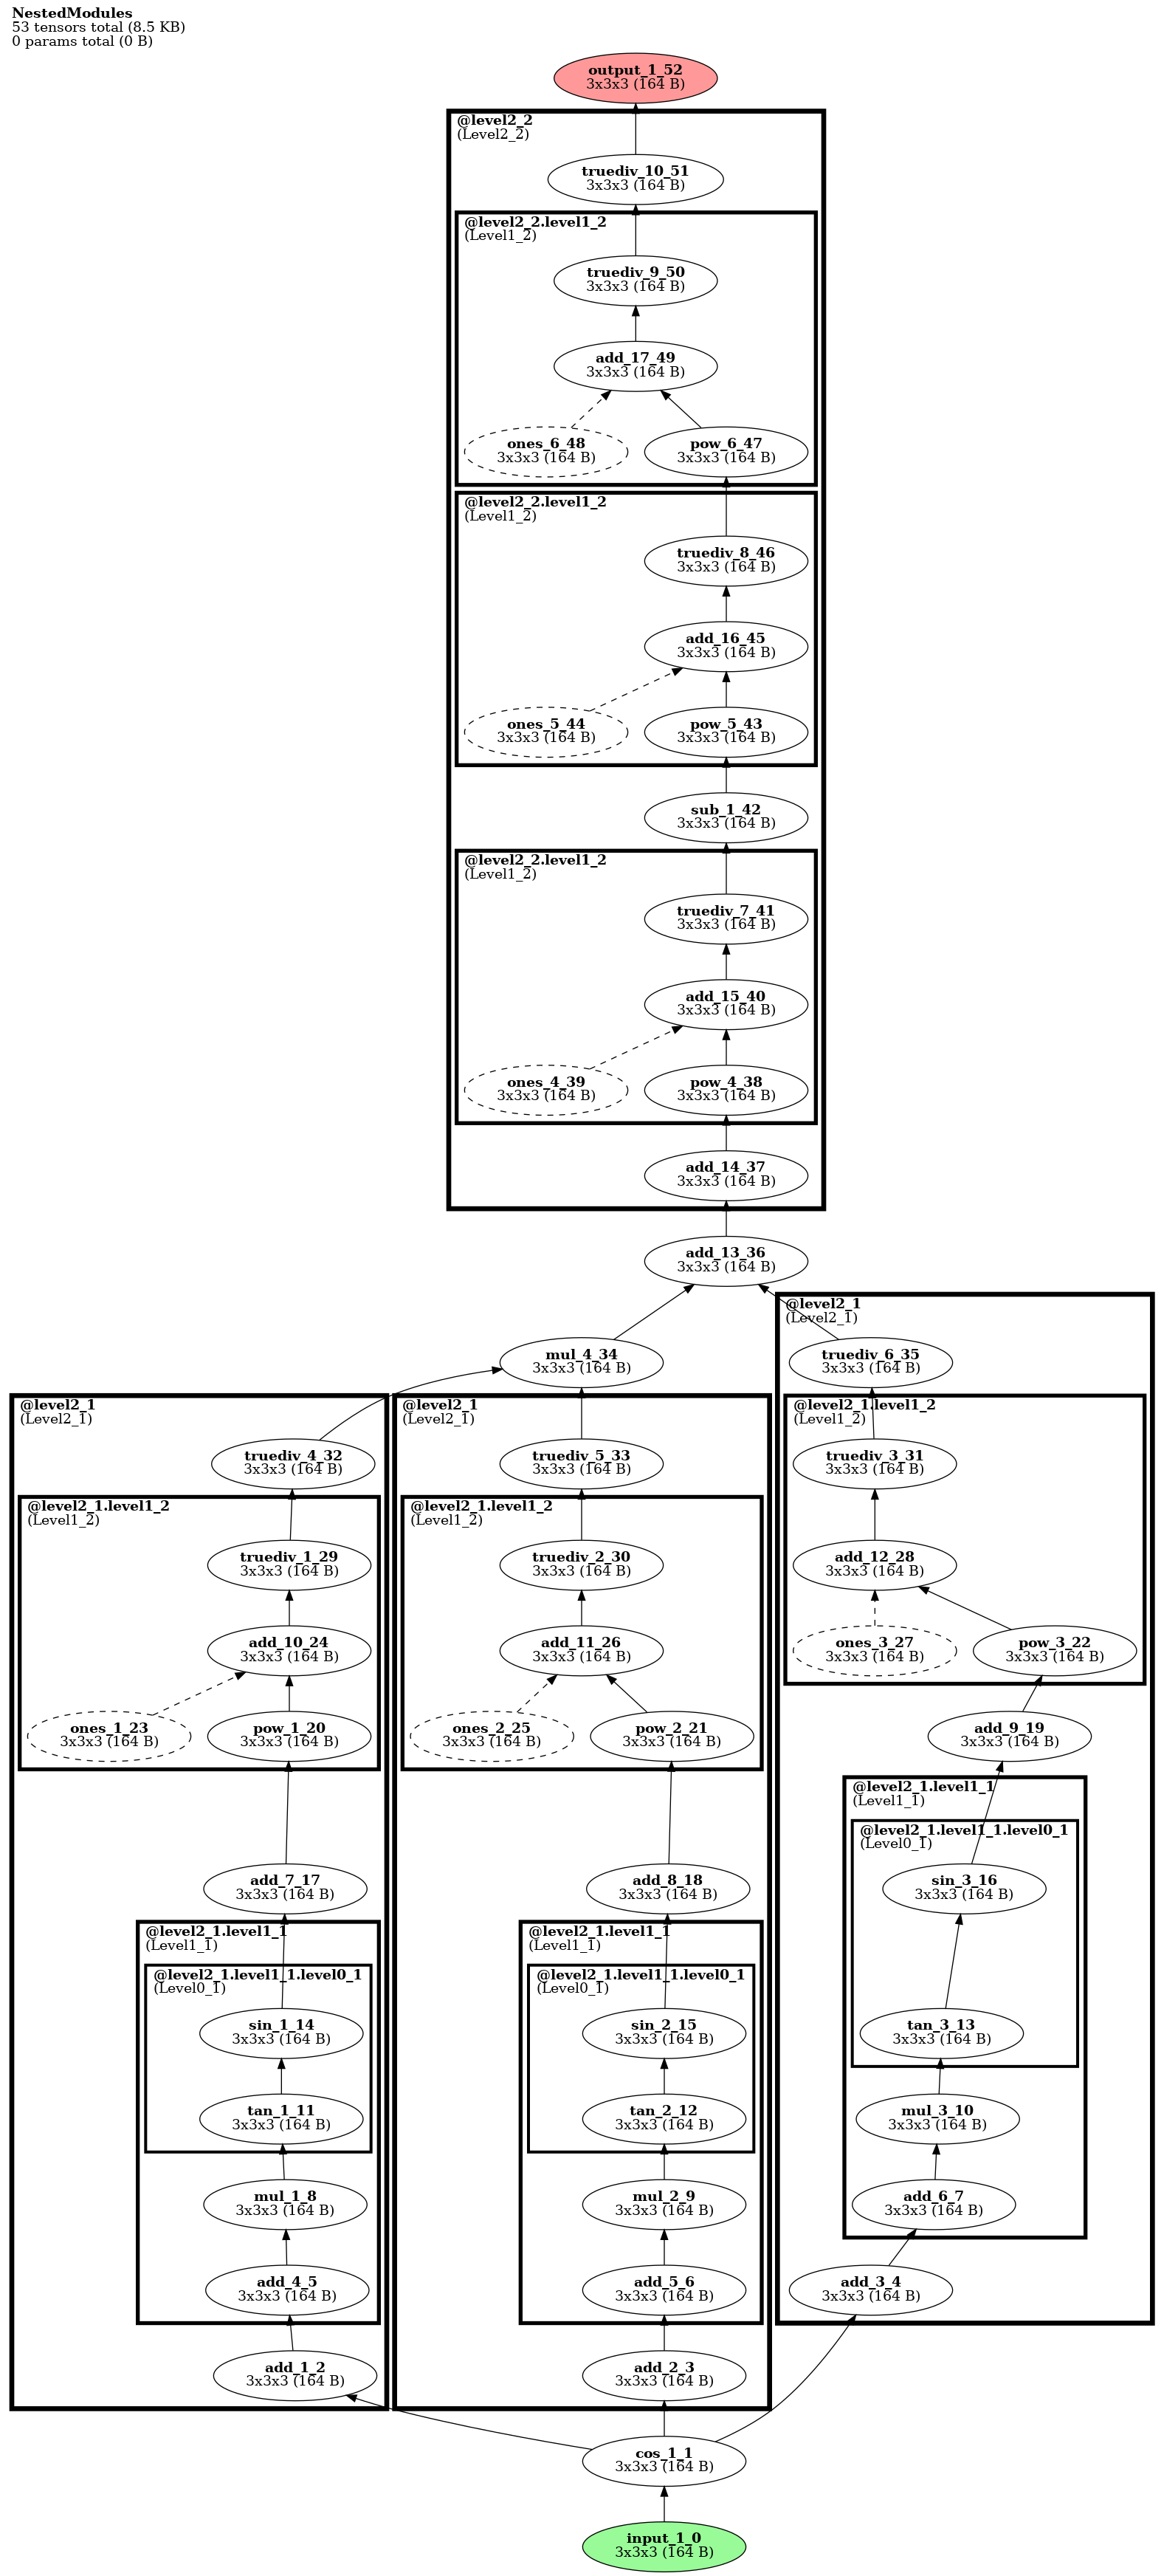

Log of NestedModules forward pass:
	Model structure: purely feedforward, with branching; 6 total modules.
	53 tensors (8.5 KB) computed in forward pass; 53 tensors (8.5 KB) saved.
	0 parameter operations (0 params total; 0 B).
	Random seed: 1166079731
	Time elapsed: 0.054s
	Module Hierarchy:
		level2_1:
		    level2_1.level1_1
		        level2_1.level1_1.level0_1
		    level2_1.level1_2:
		level2_1:
		    level2_1.level1_1
		        level2_1.level1_1.level0_1
		    level2_1.level1_2:
		level2_1:
		    level2_1.level1_1
		        level2_1.level1_1.level0_1
		    level2_1.level1_2:
		level2_2:
		    level2_2.level1_2, level2_2.level1_2, level2_2.level1_2
	Layers:
		0: input_1_0 
		1: cos_1_1 
		2: add_1_2 
		3: add_2_3 
		4: add_3_4 
		5: add_4_5 
		6: add_5_6 
		7: add_6_7 
		8: mul_1_8 
		9: mul_2_9 
		10: mul_3_10 
		11: tan_1_11 
		12: tan_2_12 
		13: tan_3_13 
		14: sin_1_14 
		15: sin_2_15 
		16: sin_3_16 
		17: add_7_17 
		18: add_8_18 
		19: add_9_19 
		20: pow_1_20 
		21: pow_2_

In [20]:
# Model with nested modules

class Level0_1(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = torch.tan(x)
        x = torch.sin(x)
        return x


class Level1_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.level0_1 = Level0_1()

    def forward(self, x):
        x = x + 1
        x = x * 2
        x = self.level0_1(x)
        return x


class Level1_2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x ** 3 + torch.ones(x.shape)
        x = x / 5
        return x


class Level2_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.level1_1 = Level1_1()
        self.level1_2 = Level1_2()

    def forward(self, x):
        x = x + 1
        x = self.level1_1(x)
        x = x + 9
        x = self.level1_2(x)
        x = x / 5
        return x


class Level2_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.level1_1 = Level1_1()
        self.level1_2 = Level1_2()

    def forward(self, x):
        x = x + 9
        x = self.level1_2(x)
        x = x - 5
        x = self.level1_2(self.level1_2(x))
        x = x / 5
        return x


class NestedModules(nn.Module):
    def __init__(self):
        super().__init__()
        self.level2_1 = Level2_1()
        self.level2_2 = Level2_2()

    def forward(self, x):
        x = torch.cos(x)
        x1 = self.level2_1(x)
        x2 = self.level2_1(x)
        x3 = self.level2_1(x)
        x = x1 * x2 + x3
        x = self.level2_2(x)
        return x


nested_module_model = NestedModules()
x = torch.rand(3, 3, 3)
tl.get_model_activations(nested_module_model, x, vis_opt='unrolled')

#### Models with Randomness

Some models might incorporate randomness; for instance, perhaps they add randomly generated noise at some stage. Torchlens allows you to set the random seed you wish to use in order to ensure replicability. To illustrate this easily, in this model there is a recurrent loop that will repeat a random number of times; see that different seeds cause different numbers of repeats, but using the same seed ensures the same behavior:

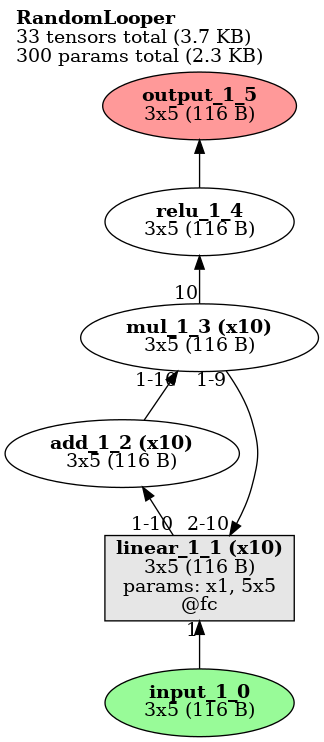

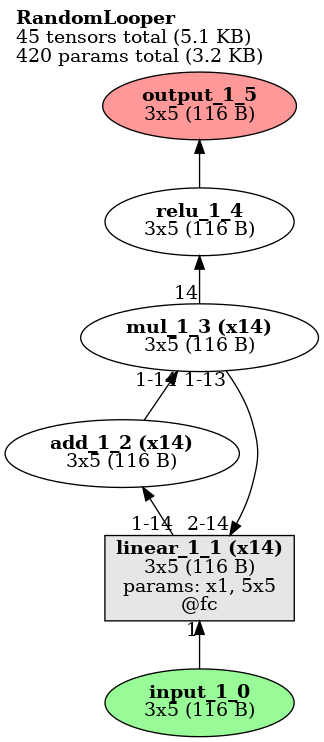

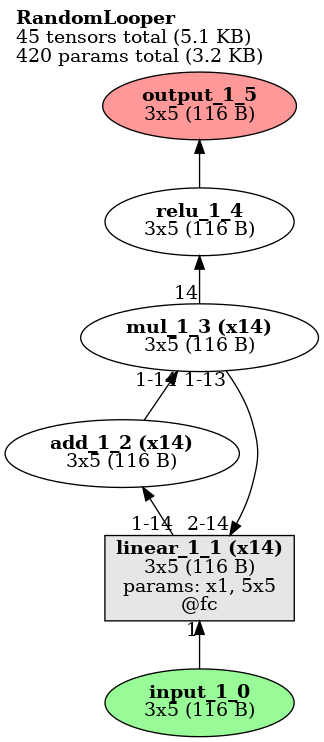

Log of RandomLooper forward pass:
	Model structure: recurrent (at most 14 loops), without branching; 1 total modules.
	45 tensors (5.1 KB) computed in forward pass; 45 tensors (5.1 KB) saved.
	28 parameter operations (420 params total; 3.2 KB).
	Random seed: 19
	Time elapsed: 0.096s
	Module Hierarchy:
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
		fc
	Layers:
		0: input_1_0 
		1: linear_1_1:1  (1/14 passes)
		2: add_1_2:1  (1/14 passes)
		3: mul_1_3:1  (1/14 passes)
		4: linear_1_1:2  (2/14 passes)
		5: add_1_2:2  (2/14 passes)
		6: mul_1_3:2  (2/14 passes)
		7: linear_1_1:3  (3/14 passes)
		8: add_1_2:3  (3/14 passes)
		9: mul_1_3:3  (3/14 passes)
		10: linear_1_1:4  (4/14 passes)
		11: add_1_2:4  (4/14 passes)
		12: mul_1_3:4  (4/14 passes)
		13: linear_1_1:5  (5/14 passes)
		14: add_1_2:5  (5/14 passes)
		15: mul_1_3:5  (5/14 passes)
		16: linear_1_1:6  (6/14 passes)
		17: add_1_2:6  (6/14 passes)
		18: mul_1_3:6  (6/14 passes)
		19: linear_1_1:7  (7/14 passes)
	

In [21]:
import numpy as np


class RandomLooper(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(5, 5)

    def forward(self, x):
        num_repeats = np.random.choice(range(20))
        for repeat in range(num_repeats):
            x = self.fc(x)
            x = x + 5
            x = x * 2
        x = nn.functional.relu(x)
        return x


x = torch.rand(3, 5)
random_model = RandomLooper()
tl.get_model_activations(random_model, x, random_seed=3, vis_opt='rolled')
tl.get_model_activations(random_model, x, random_seed=19, vis_opt='rolled')
tl.get_model_activations(random_model, x, random_seed=19, vis_opt='rolled')


#### CORNet_S: A complex model

Finally, torchlens can work for complex models too: here it is for [cornet_s](https://dicarlolab.mit.edu/cornet-modeling-neural-mechanisms-core-object-recognition), which contains recurrence, branching, and multiple modules. You can see from the visual that it's quite complex (even in the 'rolled up' format to make it more compact), though breaking it into modules makes it easier to understand:

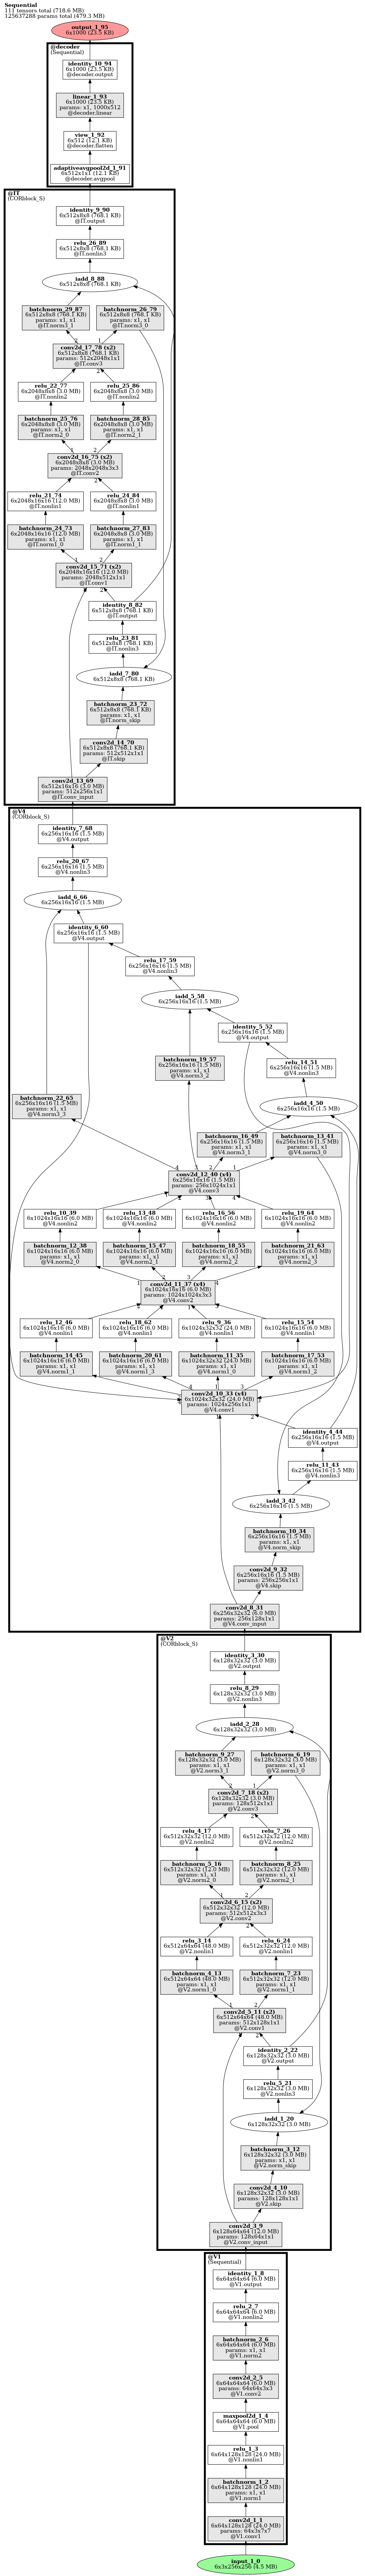

In [22]:
x = torch.rand(6, 3, 256, 256)
cornet_model = cornet_s()
tl.show_model_graph(cornet_model, x, vis_opt='rolled')

The visual makes it easy to pick out layers we might want to save; for instance, perhaps we want the output of the main modules (V1, V2, V4, IT, and decoder), and all the passes of the final convolutional layer in the recurrent loop of V4 (if a layer has multiple passes and you include it in which_layers without a pass designated, it'll pull out all passes for that layer):

In [23]:
model_history = tl.get_model_activations(cornet_model, x, which_layers=['V1', 'V2', 'V4', 'IT', 'conv2d_12_40'])
model_history

Log of Sequential forward pass:
	Model structure: recurrent (at most 4 loops), with branching; 9 total modules.
	111 tensors (718.6 MB) computed in forward pass; 8 tensors (17.3 MB) saved.
	92 parameter operations (125637288 params total; 479.3 MB).
	Random seed: 828372595
	Time elapsed: 0.399s
	Module Hierarchy:
		V1:
		    V1.conv1, V1.norm1, V1.nonlin1, V1.pool, V1.conv2, V1.norm2, V1.nonlin2, V1.output
		V2:
		    V2.conv_input, V2.skip, V2.conv1, V2.norm_skip, V2.norm1_0, V2.nonlin1, V2.conv2, V2.norm2_0, 
		    V2.nonlin2, V2.conv3, V2.norm3_0, V2.nonlin3, V2.output, V2.conv1, V2.norm1_1, V2.nonlin1, 
		    V2.conv2, V2.norm2_1, V2.nonlin2, V2.conv3, V2.norm3_1, V2.nonlin3, V2.output
		V4:
		    V4.conv_input, V4.skip, V4.conv1, V4.norm_skip, V4.norm1_0, V4.nonlin1, V4.conv2, V4.norm2_0, 
		    V4.nonlin2, V4.conv3, V4.norm3_0, V4.nonlin3, V4.output, V4.conv1, V4.norm1_1, V4.nonlin1, 
		    V4.conv2, V4.norm2_1, V4.nonlin2, V4.conv3, V4.norm3_1, V4.nonlin3, V4.output, V4.conv1, 


The goal of torchlens is to automatically work for any PyTorch model whatsoever. It has been tested for all models in torchvision's model zoo, but to validate the correctness of any saved activations for untested models, there is one more core function, validate_saved_activations, which algorithmically verifies that the model's activations are correctly saved by re-running the forward pass from each intermediate step of the model based on the saved activations and checking that the resulting output matches the ground truth. Additionally, as a further check, it substitutes in random nonsense activations in place of the saved activations during each step of this validation procedure, and verifies that the resulting output does *not* match the ground truth output. This function returns True if the saved activations pass this test, and False otherwise.

In [24]:
x = torch.rand(6, 3, 256, 256)
tl.validate_saved_activations(alexnet, x)

True

We see that re-running AlexNet's forward pass from any of the saved activations correctly recovers the ground truth output, and altering these saved activations changes the ground truth output, giving us confidence that it in fact saved the activations correctly.

<u>Please email johnmarkedwardtaylor@gmail.com if this ever returns False and torchlens will be updated to work with your model; this would be greatly appreciated, since it means you found a missing edge case that will also help improve torchlens for other users who might have a model with similar quirks.</u>

And that's it: one main function (get_model_activations), two secondary functions (get_model_structure and show_model_graph) to help select subsets of layers to save if not all layers are desired, and a sanity-check function (validate_saved_activations) to verify the correctness of saved activations.
